# Taller de repaso: Aprendizaje no supervisado

## Preparación del notebook

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import silhouette_score, calinski_harabasz_score
#!pip install kneed
from kneed import KneeLocator

from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA, FactorAnalysis

#!pip install factor_analyzer
from factor_analyzer import FactorAnalyzer

In [2]:
import warnings
warnings.filterwarnings('ignore')

## Lectura del dataset

Este conjunto de datos contiene una encuesta sobre la satisfacción de los pasajeros de una compañía aérea. ¿Qué factores están altamente correlacionados con un pasajero satisfecho (o insatisfecho)?

In [3]:
# Lectura del dataset
df = pd.read_csv('https://raw.githubusercontent.com/mlondono-oc/LEA2/main/Modulo-3/data/train.csv')
df.head()

,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,...,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,1,5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,...,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,2,110028,Female,Loyal Customer,26,Business travel,Business,1142,2,2,...,5,4,3,4,4,4,5,0,0.0,satisfied
3,3,24026,Female,Loyal Customer,25,Business travel,Business,562,2,5,...,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,4,119299,Male,Loyal Customer,61,Business travel,Business,214,3,3,...,3,3,4,4,3,3,3,0,0.0,satisfied


In [4]:
#Información general de las variables
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103904 entries, 0 to 103903
Data columns (total 25 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Unnamed: 0                         103904 non-null  int64  
 1   id                                 103904 non-null  int64  
 2   Gender                             103904 non-null  object 
 3   Customer Type                      103904 non-null  object 
 4   Age                                103904 non-null  int64  
 5   Type of Travel                     103904 non-null  object 
 6   Class                              103904 non-null  object 
 7   Flight Distance                    103904 non-null  int64  
 8   Inflight wifi service              103904 non-null  int64  
 9   Departure/Arrival time convenient  103904 non-null  int64  
 10  Ease of Online booking             103904 non-null  int64  
 11  Gate location                      1039

In [5]:
# Eliminación de variables no significativas
df.drop(['Unnamed: 0', 'id', ], axis=1, inplace=True)

In [8]:
# Muestra mas pequeña de datos
df_sample = df.sample(n=2500, random_state=123)
df_sample.reset_index(drop=True, inplace=True)
df_sample.shape

(2500, 23)

## EDA

In [10]:
# Comprobación de valores nulos
df_sample.isnull().sum()

Gender                               0
Customer Type                        0
Age                                  0
Type of Travel                       0
Class                                0
Flight Distance                      0
Inflight wifi service                0
Departure/Arrival time convenient    0
Ease of Online booking               0
Gate location                        0
Food and drink                       0
Online boarding                      0
Seat comfort                         0
Inflight entertainment               0
On-board service                     0
Leg room service                     0
Baggage handling                     0
Checkin service                      0
Inflight service                     0
Cleanliness                          0
Departure Delay in Minutes           0
Arrival Delay in Minutes             6
satisfaction                         0
dtype: int64

<AxesSubplot:>

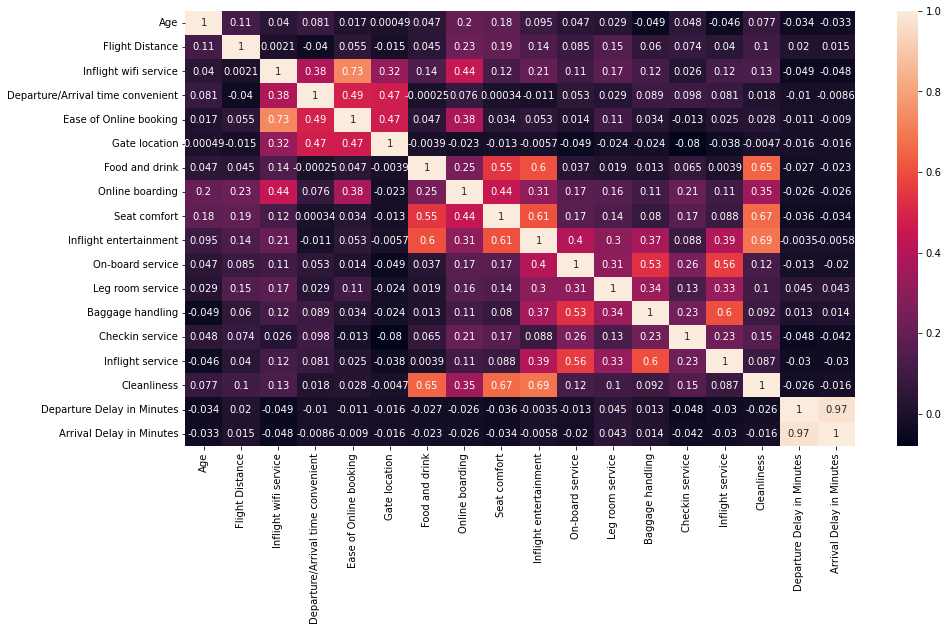

In [11]:
# Matriz de correlación
plt.figure(figsize=(15,8))
c= df_sample.corr()
sns.heatmap(c, annot=True)

In [12]:
# Eliminación de columna altamente correlacionada
df_sample.drop(['Arrival Delay in Minutes'], axis=1, inplace=True)

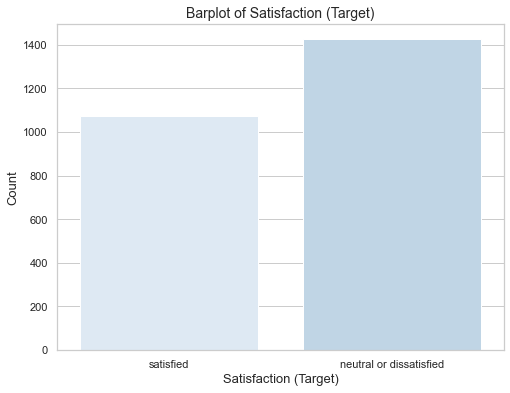

In [13]:
# Estilo de las gráficas
sns.set_theme(style='whitegrid', palette='Blues')

# Variable satisfacción
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='satisfaction', data=df_sample)
plt.title('Barplot of Satisfaction (Target)', fontsize=14)
plt.xlabel('Satisfaction (Target)', fontsize=13)
plt.ylabel('Count', fontsize=13)
plt.show()

In [14]:
# Veamos primero la puntuación media de cada clase, en las 14 variables que se encuestaron
eco = df_sample[df_sample['Class']=='Eco'][df_sample.columns[6:20]].mean().mean()
eco_plus = df_sample[df_sample['Class']=='Eco Plus'][df_sample.columns[6:20]].mean().mean()
business = df_sample[df_sample['Class']=='Business'][df_sample.columns[6:20]].mean().mean()
print(eco, eco_plus, business)

3.061215370866846 3.0516806722689074 3.4289253273563767


In [15]:
df_sample.groupby('Class')[df_sample.columns[6:20]].mean()

,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness
Class,,,,,,,,,,,,,,
Business,2.778695,2.940545,2.940545,3.006606,3.307184,3.744013,3.769612,3.624277,3.658960,3.654831,3.831544,3.487201,3.837325,3.423617
Eco,2.671135,3.180518,2.588919,3.030384,3.095621,2.781055,3.102770,3.106345,3.107239,3.090259,3.428954,3.071492,3.497766,3.104558
Eco Plus,2.776471,3.188235,2.676471,2.882353,3.105882,2.952941,3.135294,3.129412,3.035294,3.011765,3.358824,2.917647,3.470588,3.082353


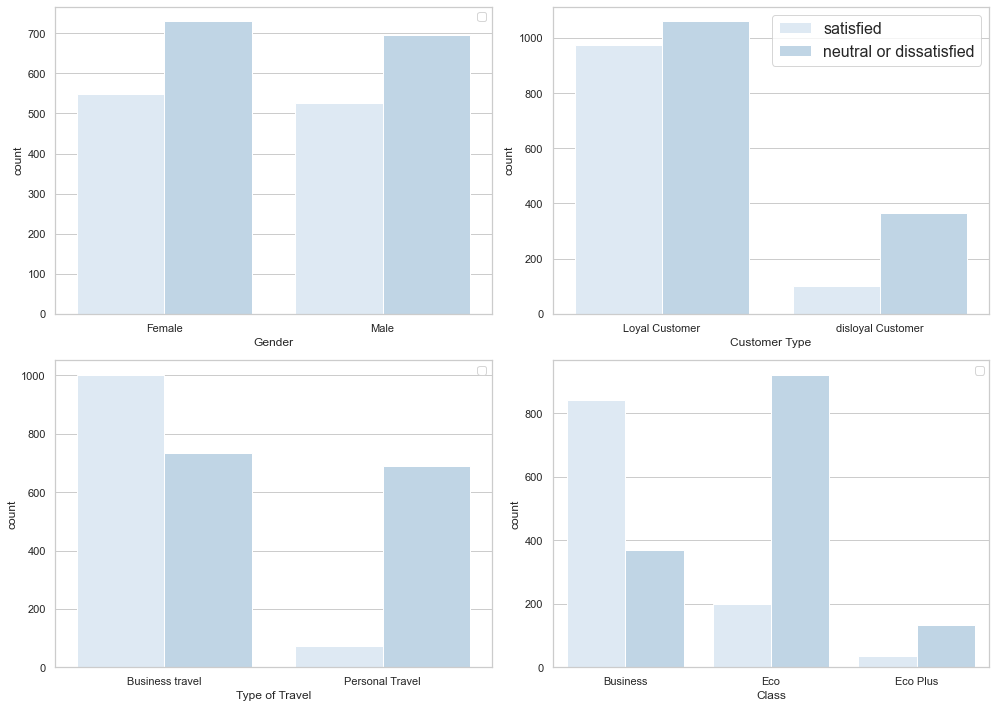

In [16]:
# Variable Categoricas
cat_cols = ['Gender', 'Customer Type', 'Type of Travel', 'Class']

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))
axs = axs.ravel()

i=0
for col in cat_cols:

    # define location
    plt.subplot(2, 2, i+1)

    # create plot
    ax = plt.gca()
    axs[i] = sns.countplot(x = col, hue = 'satisfaction', data = df_sample)

    # remove legend
    ax.legend('')

    i += 1

# add legend
axs[1].legend(loc='upper right', fontsize=16)

plt.tight_layout()
plt.show()

In [17]:
# Codificación de variable satisfacción
df_sample['satisfaction'] = df_sample['satisfaction'].map({'neutral or dissatisfied':0, 'satisfied':1})

In [18]:
#  Revisión Clase Eco
eco_proportion = len(df_sample[df_sample['Class']=='Eco'])/len(df_sample)
bad_proportion = len(df_sample[df_sample['Class']=='Eco']['satisfaction']==0)/len(df_sample[df_sample['satisfaction']==0])
print(eco_proportion*100, bad_proportion*100)

44.76 78.52631578947368


## Pre procesamiento de los datos

In [19]:
# Metodología 1
train_df1 = df_sample.copy()
train_df1['Gender'] = train_df1['Gender'].map({'Female':0, 'Male':1})
train_df1['Customer Type'] = train_df1['Customer Type'].map({'disloyal Customer':0, 'Loyal Customer':1})
train_df1['Type of Travel'] = train_df1['Type of Travel'].map({'Personal Travel':0, 'Business travel':1})
train_df1['Class'] = train_df1['Class'].map({'Eco':1, 'Eco Plus':2, 'Business':3})

train_df1.head(3)

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,...,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,satisfaction
0,0,1,46,1,3,2954,2,2,2,2,...,4,4,4,4,4,5,4,3,10,1
1,1,1,45,1,3,397,2,1,1,1,...,3,2,2,2,2,2,2,4,0,0
2,0,1,30,0,1,338,2,2,2,4,...,2,2,4,2,3,3,4,2,0,0


In [20]:
# Metodología 2
train_df2 = df_sample.copy()
train_df2['Gender'] = train_df2['Gender'].map({'Female':0, 'Male':1})
train_df2['Customer Type'] = train_df2['Customer Type'].map({'disloyal Customer':0, 'Loyal Customer':1})
train_df2['Type of Travel'] = train_df2['Type of Travel'].map({'Personal Travel':0, 'Business travel':1})

# Calcular la frecuencia de cada categoría Class
frecuencia = train_df2['Class'].value_counts(normalize=True)
# Aplicar la codificación de frecuencia
train_df2['Class'] = train_df2['Class'].map(frecuencia)

train_df2.head(3)

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,...,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,satisfaction
0,0,1,46,1,0.4844,2954,2,2,2,2,...,4,4,4,4,4,5,4,3,10,1
1,1,1,45,1,0.4844,397,2,1,1,1,...,3,2,2,2,2,2,2,4,0,0
2,0,1,30,0,0.4476,338,2,2,2,4,...,2,2,4,2,3,3,4,2,0,0


In [21]:
train_df1.shape

(2500, 22)

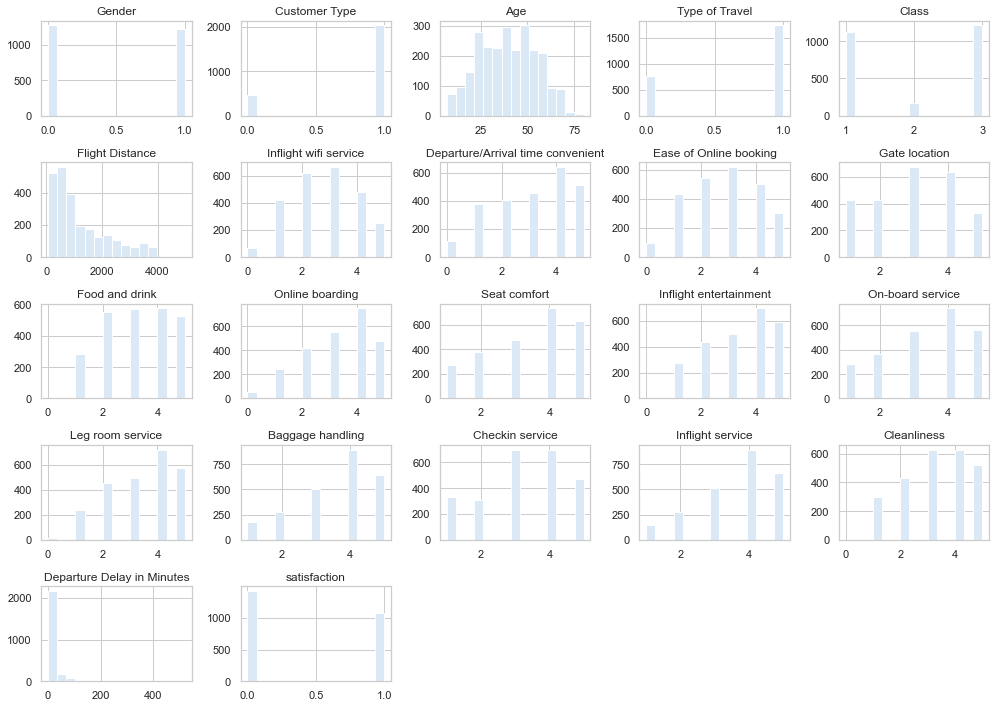

In [22]:
train_df1.hist(figsize=(14,10), bins=15)
plt.tight_layout()
plt.show()

In [23]:
# Escalado de variables numéricas
train_cols = train_df1[['Age', 'Flight Distance', 'Departure Delay in Minutes']]

scaler = StandardScaler()
scaled_train_df1 = pd.DataFrame(scaler.fit_transform(train_cols), columns = train_cols.columns)
scaled_train_df1.head(3)

,Age,Flight Distance,Departure Delay in Minutes
0,0.428280,1.712718,-0.146356
1,0.362354,-0.806434,-0.394517
2,-0.626532,-0.864560,-0.394517


In [24]:
#  Union de data numéricas  y categórica
cols = ['Age', 'Flight Distance', 'Departure Delay in Minutes']
train_df1[cols] = scaled_train_df1
train_df2[cols] = scaled_train_df1
train_df1.head(3)

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,...,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,satisfaction
0,0,1,0.428280,1,3,1.712718,2,2,2,2,...,4,4,4,4,4,5,4,3,-0.146356,1
1,1,1,0.362354,1,3,-0.806434,2,1,1,1,...,3,2,2,2,2,2,2,4,-0.394517,0
2,0,1,-0.626532,0,1,-0.864560,2,2,2,4,...,2,2,4,2,3,3,4,2,-0.394517,0


In [25]:
train_df2.head(3)

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,...,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,satisfaction
0,0,1,0.428280,1,0.4844,1.712718,2,2,2,2,...,4,4,4,4,4,5,4,3,-0.146356,1
1,1,1,0.362354,1,0.4844,-0.806434,2,1,1,1,...,3,2,2,2,2,2,2,4,-0.394517,0
2,0,1,-0.626532,0,0.4476,-0.864560,2,2,2,4,...,2,2,4,2,3,3,4,2,-0.394517,0


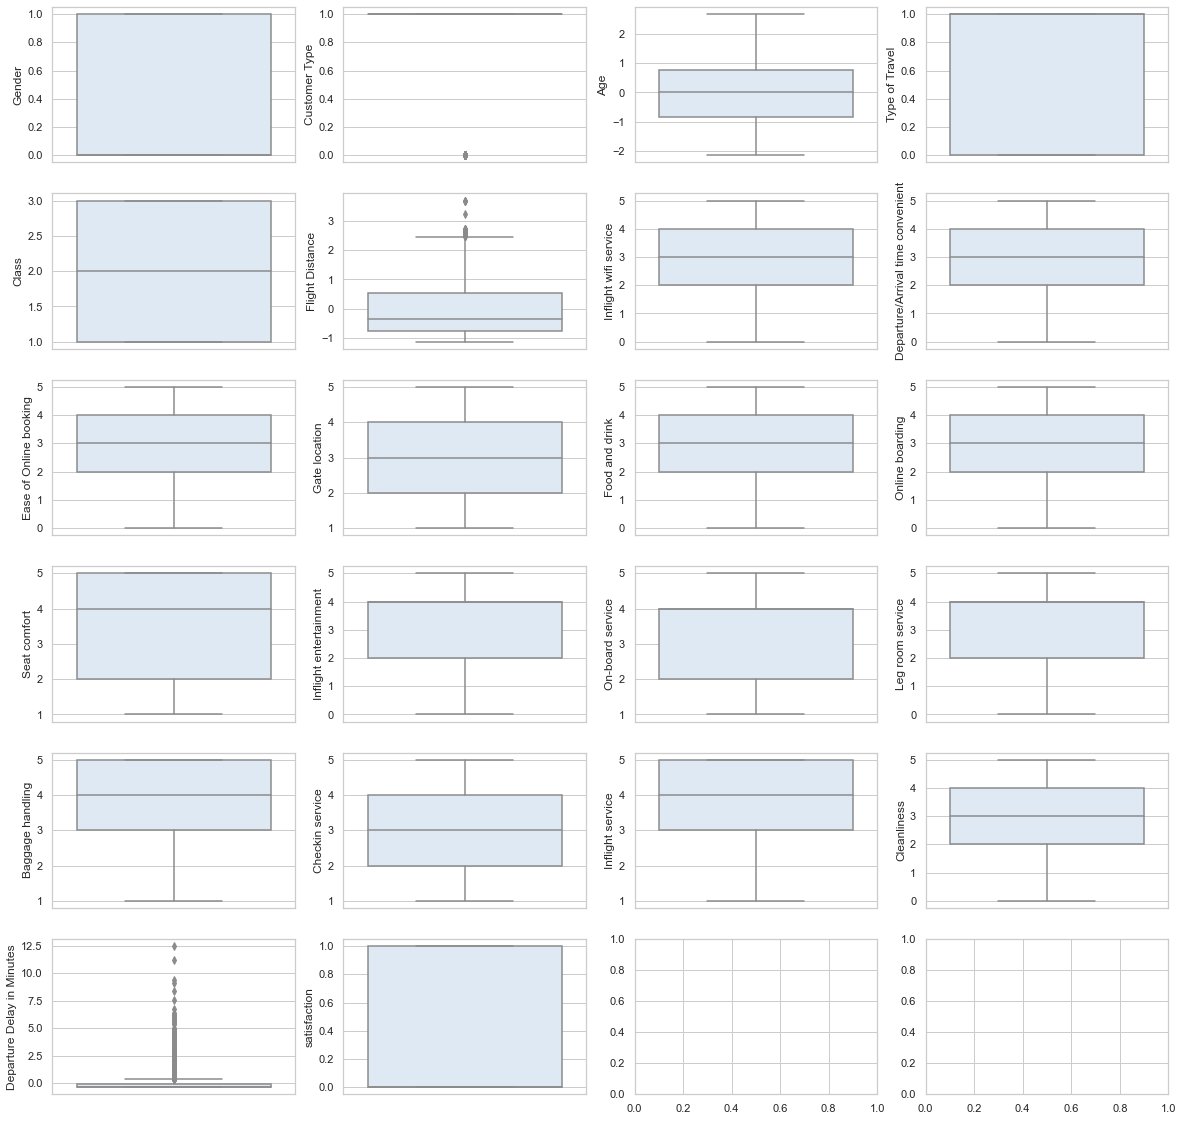

In [26]:
# Tratamiento de valores atípicos
train_df1_out = train_df1.copy()

# Sentar las bases de un "mosaico boxplot de 6x4 (para cubrir 22 variables)":
box_locs=pd.DataFrame(
{"vert":sorted(list(range(0,6))*4),
 "horiz":list(range(0,4))*6}
)

fig,axs=plt.subplots(ncols=4,nrows=6,figsize=(20,20))

for idx,i in enumerate(train_df1_out.columns):
    sns.boxplot(y=train_df1_out[i],ax=axs[box_locs.iloc[idx,0]][box_locs.iloc[idx,1]])

In [27]:
# Take indices of all the outliers:
outs_idx=[train_df1_out[train_df1_out['Flight Distance'] > 2.5]['Flight Distance'].index.astype('int'),
          train_df1_out[train_df1_out['Departure Delay in Minutes'] > 10]['Departure Delay in Minutes'].index.astype('int')]

# Select unique ones and sort them:
outs_idx=pd.Series(sorted(np.concatenate(outs_idx))).unique()

# Drop these rows from 'train_df1_out', don't forget to RESET INDICES afterwards:
train_df1_out.drop(index=outs_idx,inplace=True) # 57 valores atípicos
train_df1_out.reset_index(drop=True,inplace=True)


In [28]:
train_df1_out.shape

(2443, 22)

In [29]:
train_df1.shape

(2500, 22)

## Reducción dimensionalidad

In [30]:
#Cree un dataset reducido que proporcione el 85% de la varianza de entrada que debe explicarse
pca = PCA(n_components=0.85).fit(train_df1_out)

#Veamos cuántas componentes ha conservado PCA:
pca.n_components_

11

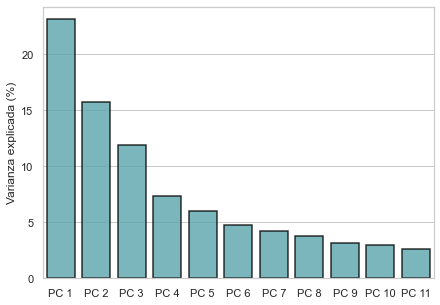

In [31]:
# --- Varianza explicada ---
PCA_variance = pd.DataFrame({'Varianza explicada (%)':
                             pca.explained_variance_ratio_*100})

fig, ax = plt.subplots(1, 1, figsize = (7, 5))

bar = sns.barplot(x = ['PC ' + str(i) for i in range(1, 12)],
                  y = PCA_variance['Varianza explicada (%)'],
                  linewidth = 1.5, edgecolor = 'k', color = '#4bafb8',
                  alpha = 0.8)

plt.show()

In [32]:
PCA_variance

,Varianza explicada (%)
0,23.106581
1,15.725719
2,11.912787
3,7.363197
4,5.979603
5,4.745311
6,4.208387
7,3.806548
8,3.143799
9,2.945397


In [33]:
#Por último, transforme "train_df1_out" de 22 columnas X_pca
X_pca = pca.fit_transform(train_df1_out)
X_pca

array([[-2.01762899e+00,  2.32663125e+00,  3.85829602e-01, ...,
         1.98386632e-03, -5.94537979e-01,  1.14700595e+00],
       [ 2.30421434e+00,  2.51777661e+00, -2.83563200e+00, ...,
        -1.24043333e-01, -4.98826896e-01,  2.58322759e-01],
       [ 3.22437091e+00, -1.29847185e-01,  9.23453432e-01, ...,
        -8.25834398e-01,  9.70755495e-01, -4.77600716e-01],
       ...,
       [-2.51486340e+00,  6.00944542e-01,  1.35719371e+00, ...,
         5.83455323e-01, -2.24830472e+00, -8.14183505e-01],
       [ 3.06576099e-01,  5.58866583e-01, -2.29289501e+00, ...,
        -9.98505198e-02,  3.28501348e-01, -6.79986256e-02],
       [ 7.70273956e-01,  4.31886538e-03, -2.56656286e-02, ...,
        -9.64240147e-02, -5.12476671e-01, -4.77623328e-02]])

## Clustering Algorithm: K-Means

### Dataset  Original Escalado

In [34]:
# Número optimo de K
inertia_list = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=3)
    kmeans.fit(train_df1_out)
    inertia_list.append(kmeans.inertia_)

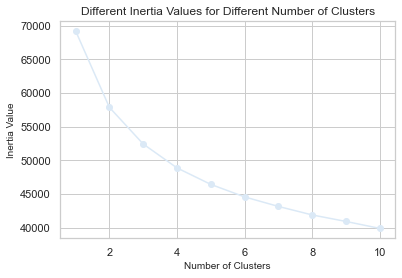

In [35]:
# plot the inertia curve
plt.plot(range(1,11),inertia_list)
plt.scatter(range(1,11),inertia_list)
plt.xlabel("Number of Clusters", size=10)
plt.ylabel("Inertia Value", size=10)
plt.title("Different Inertia Values for Different Number of Clusters", size=12)
plt.show()

In [36]:
# Seleccion automatica del numero k
kl = KneeLocator(range(1, 11),
                 inertia_list, curve="convex",
                 direction="decreasing")
kl.elbow

4

In [37]:
kmeans_constants = {"init": "k-means++", "n_init": 100, "max_iter": 500, "random_state": 42}

# --- Modelo K-means ---
model_kmeans = KMeans(n_clusters = 4, **kmeans_constants)
model_kmeans.fit(train_df1_out)

KMeans(max_iter=500, n_clusters=4, n_init=100, random_state=42)

**Evaluación del algoritmos**

**Calinski Harabasz Score:**

El índice Calinski-Harabasz se basa en la comparación de la relación ponderada entre la suma de los cuadrados (la medida de la separación del clúster) y la suma de los cuadrados dentro del clúster (la medida de cómo se empaquetan estrechamente los puntos dentro de un clúster).

Las soluciones de clúster con valores más grandes del índice corresponden a soluciones "mejores" que las soluciones de clúster con valores más pequeños.

In [38]:
# --- Evaluación del modelo kmeans ---
print(" ### K-MEANS ###")
print('Inertia: ', model_kmeans.inertia_)
print('Silhouette Score: ', silhouette_score(train_df1_out, model_kmeans.labels_))
print('Calinski harabasz score: ', calinski_harabasz_score(train_df1_out, model_kmeans.labels_))

 ### K-MEANS ###
Inertia:  48886.85805152735
Silhouette Score:  0.1273188588391856
Calinski harabasz score:  338.60210251738954


In [39]:
# Predicción de los clusters
Cluster_1 = model_kmeans.fit_predict(train_df1_out)
Cluster_1

array([1, 0, 3, ..., 2, 0, 0], dtype=int32)

In [40]:
# Vamos a adjuntar 'Cluster_1' como una nueva variable a 'train_df1_out':
df_final = train_df1_out.copy()
df_final['Cluster_1']= Cluster_1

# A partir de ahora, sólo trabajaremos con "df_final"
df_final.head()

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,satisfaction,Cluster_1
0,0,1,0.428280,1,3,1.712718,2,2,2,2,...,4,4,4,4,5,4,3,-0.146356,1,1
1,1,1,0.362354,1,3,-0.806434,2,1,1,1,...,2,2,2,2,2,2,4,-0.394517,0,0
2,0,1,-0.626532,0,1,-0.864560,2,2,2,4,...,2,4,2,3,3,4,2,-0.394517,0,3
3,1,1,-0.230977,1,2,-0.758159,4,3,3,3,...,4,4,3,4,4,3,4,-0.394517,0,2
4,1,1,1.021611,0,1,-0.829093,3,4,3,3,...,4,3,4,5,2,5,2,4.618348,0,3


In [41]:
df_final.Cluster_1.unique()

array([1, 0, 3, 2], dtype=int32)

### Dataset Reducido

In [42]:
# Número optimo de K
inertia_list = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=3)
    kmeans.fit(X_pca)
    inertia_list.append(kmeans.inertia_)

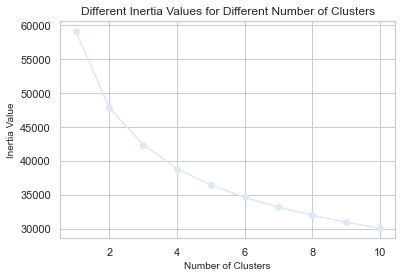

In [43]:
# plot the inertia curve
plt.plot(range(1,11),inertia_list)
plt.scatter(range(1,11),inertia_list)
plt.xlabel("Number of Clusters", size=10)
plt.ylabel("Inertia Value", size=10)
plt.title("Different Inertia Values for Different Number of Clusters", size=12)
plt.show()

In [44]:
# Seleccion automatica del numero k
kl = KneeLocator(range(1, 11),
                 inertia_list, curve="convex",
                 direction="decreasing")
kl.elbow

4

In [45]:
kmeans_constants = {"init": "k-means++", "n_init": 100, "max_iter": 500, "random_state": 42}

# --- Modelo K-means ---
model_kmeans_pca = KMeans(n_clusters = 4, **kmeans_constants)
model_kmeans_pca.fit(X_pca)

KMeans(max_iter=500, n_clusters=4, n_init=100, random_state=42)

In [46]:
# --- Evaluación del modelo kmeans ---
print(" ### K-MEANS ###")
print('Inertia: ', model_kmeans_pca.inertia_)
print('Silhouette Score: ', silhouette_score(X_pca, model_kmeans_pca.labels_))
print('Calinski harabasz score: ', calinski_harabasz_score(X_pca, model_kmeans_pca.labels_))

 ### K-MEANS ###
Inertia:  38887.354185309756
Silhouette Score:  0.15209945281311352
Calinski harabasz score:  424.96283810978497


In [47]:
# Predicción de los clusters
Cluster_2 = model_kmeans.fit_predict(X_pca)

df_final['Cluster_2']= Cluster_2

# A partir de ahora, sólo trabajaremos con "df_final"
df_final.head(3)

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,...,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,satisfaction,Cluster_1,Cluster_2
0,0,1,0.428280,1,3,1.712718,2,2,2,2,...,4,4,4,5,4,3,-0.146356,1,1,0
1,1,1,0.362354,1,3,-0.806434,2,1,1,1,...,2,2,2,2,2,4,-0.394517,0,0,1
2,0,1,-0.626532,0,1,-0.864560,2,2,2,4,...,4,2,3,3,4,2,-0.394517,0,3,2


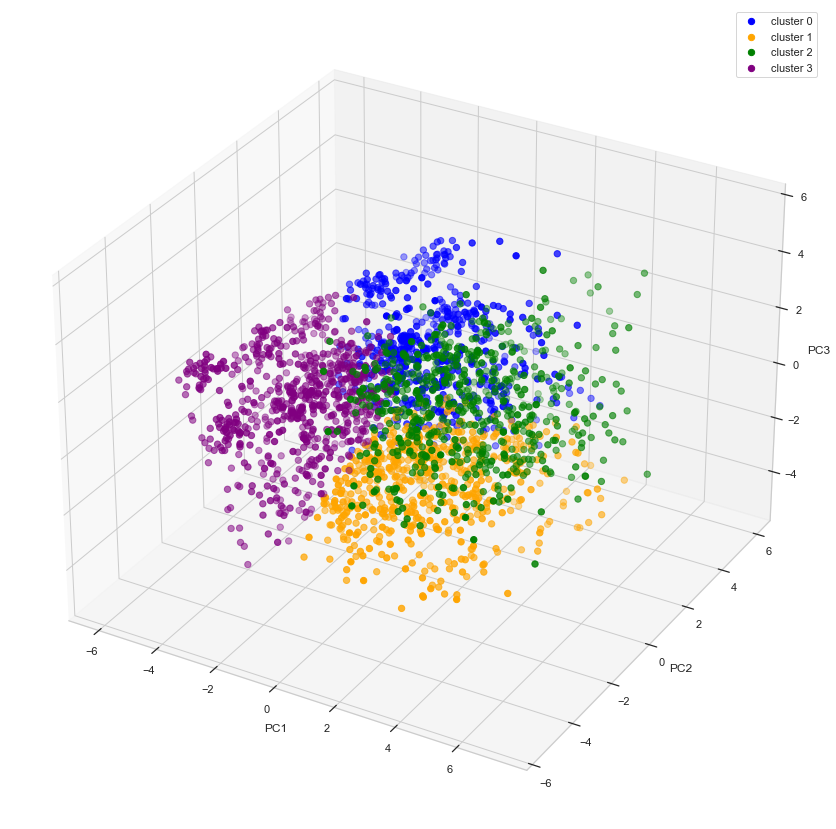

In [48]:
# 3d scatterplot using matplotlib

fig = plt.figure(figsize = (15,15))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_pca[Cluster_2 == 0,0],X_pca[Cluster_2 == 0,1],X_pca[Cluster_2 == 0,2], s = 40 , color = 'blue', label = "cluster 0")
ax.scatter(X_pca[Cluster_2 == 1,0],X_pca[Cluster_2 == 1,1],X_pca[Cluster_2 == 1,2], s = 40 , color = 'orange', label = "cluster 1")
ax.scatter(X_pca[Cluster_2 == 2,0],X_pca[Cluster_2 == 2,1],X_pca[Cluster_2 == 2,2], s = 40 , color = 'green', label = "cluster 2")
ax.scatter(X_pca[Cluster_2 == 3,0],X_pca[Cluster_2 == 3,1],X_pca[Cluster_2 == 3,2], s = 40 , color = 'purple', label = "cluster 3")
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.legend()
plt.show()

## Clustering Algorithm: Hierarchical Clustering

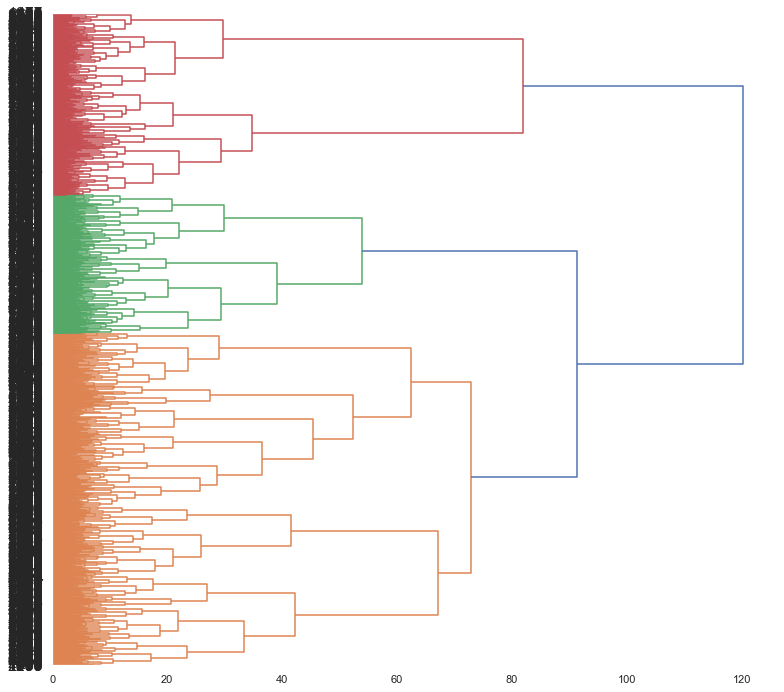

In [50]:
from scipy.cluster.hierarchy import dendrogram, linkage
# Estilo de las gráficas
sns.set_theme()

# Función de vinculación para agrupar datos según similud
Z = linkage(train_df1_out, method='ward')

plt.figure(figsize=(13, 12))
dendrogram(
    Z,
    orientation='right',
    distance_sort='descending',
    show_leaf_counts=False,
    leaf_font_size=16
)
plt.show()

In [51]:
from sklearn.cluster import AgglomerativeClustering

model_hc = AgglomerativeClustering(n_clusters = 4, metric = 'euclidean', linkage = 'ward')
model_hc.fit(train_df1_out)

# --- Evaluación del modelo kmeans ---
print(" ### HIERARCHICAL CLUSTERING ###")
print('Silhouette Score: ', silhouette_score(train_df1_out, model_hc.labels_))
print('Calinski harabasz score: ', calinski_harabasz_score(train_df1_out, model_hc.labels_))

 ### HIERARCHICAL CLUSTERING ###
Silhouette Score:  0.04928929774071638
Calinski harabasz score:  220.02138146269496


In [52]:
# Predicción de los clusters
Cluster_3 = model_hc.fit_predict(train_df1_out)

df_final['Cluster_3']= Cluster_3

# A partir de ahora, sólo trabajaremos con "df_final"
df_final.head(3)

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,...,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,satisfaction,Cluster_1,Cluster_2,Cluster_3
0,0,1,0.428280,1,3,1.712718,2,2,2,2,...,4,4,5,4,3,-0.146356,1,1,0,1
1,1,1,0.362354,1,3,-0.806434,2,1,1,1,...,2,2,2,2,4,-0.394517,0,0,1,0
2,0,1,-0.626532,0,1,-0.864560,2,2,2,4,...,2,3,3,4,2,-0.394517,0,3,2,2


## Clustering Algorithm: DBSCAN

### Dataset Original

In [53]:
from sklearn.neighbors import NearestNeighbors

# --- Selección de hiperparámetros eps ---

# --- Gráfica de distancias K --
neighbors = NearestNeighbors(n_neighbors = 2)
neighbors.fit(train_df1_out)

distances, *other = neighbors.kneighbors(train_df1_out)
distances = distances[:, 1]
print(distances.shape)
distances = np.sort(distances, axis = 0)

(2443,)


array([0.53388035, 0.53388035, 0.67876786, ..., 5.85182835, 6.03248489,
       6.08240575])

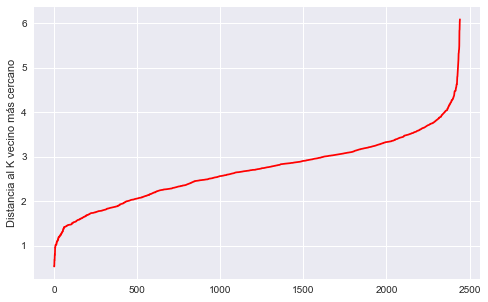

In [54]:
plt.style.use('seaborn')
plt.figure(figsize = (8, 5))
plt.plot(distances, color = 'red')
plt.ylabel('Distancia al K vecino más cercano')
plt.show()

In [55]:
# --- Selección del punto de curvatura máxima ---
kl = KneeLocator(range(len(distances)), distances, curve = 'convex', direction = 'increasing')
kl.elbow

2424

In [56]:
# --- Epsilon óptimo --
epsilon = distances[kl.elbow]
epsilon

4.625494845860773

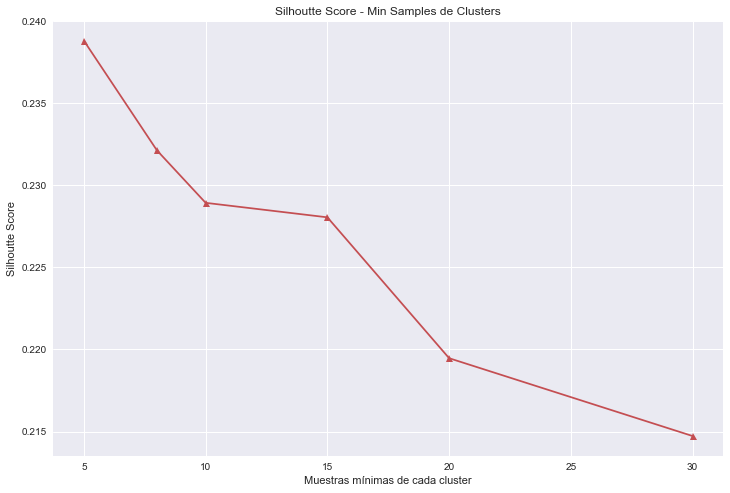

In [58]:
# --- Selección de hiperparámetros min_sample ---
silhoutte_coefs = []

for min_points in [5, 8, 10, 15, 20, 30]:
    model_d = DBSCAN(eps = epsilon, min_samples = min_points)
    model_d.fit(train_df1_out)
    silhoutte_coefs.append(silhouette_score(train_df1_out, model_d.labels_))

plt.figure(figsize = (12, 8))
plt.plot([5, 8, 10, 15, 20, 30], silhoutte_coefs, color = 'r', marker = '^')
plt.xlabel('Muestras mínimas de cada cluster')
plt.ylabel('Silhoutte Score')
plt.title('Silhoutte Score - Min Samples de Clusters')
plt.show()

In [59]:
# --- Modelo DBSCAN ---
model_db = DBSCAN(eps = epsilon, min_samples = 5, n_jobs=-1)
model_db.fit(train_df1_out)

DBSCAN(eps=4.625494845860773, n_jobs=-1)

In [60]:
# --- Evaluación del modelo DBSCAN ---
print(" ### DBSCAN ###")
print('Silhouette Score: ', silhouette_score(train_df1_out, model_db.labels_))
print('Calinski harabasz score: ', calinski_harabasz_score(train_df1_out, model_db.labels_))

 ### DBSCAN ###
Silhouette Score:  0.23880208192373484
Calinski harabasz score:  16.166930783350725


In [61]:
# Predicción de los clusters
Cluster_4 = model_db.fit_predict(train_df1_out)

df_final['Cluster_4']= Cluster_4

# A partir de ahora, sólo trabajaremos con "df_final"
df_final.head(3)

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,...,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,satisfaction,Cluster_1,Cluster_2,Cluster_3,Cluster_4
0,0,1,0.428280,1,3,1.712718,2,2,2,2,...,4,5,4,3,-0.146356,1,1,0,1,0
1,1,1,0.362354,1,3,-0.806434,2,1,1,1,...,2,2,2,4,-0.394517,0,0,1,0,0
2,0,1,-0.626532,0,1,-0.864560,2,2,2,4,...,3,3,4,2,-0.394517,0,3,2,2,0


In [63]:
df_final['Cluster_4'].value_counts()

 0    2418
-1      25
Name: Cluster_4, dtype: int64

### Dataset reducido

In [64]:
# --- Selección de hiperparámetros eps ---

# --- Gráfica de distancias K --
neighbors = NearestNeighbors(n_neighbors = 2)
neighbors.fit(X_pca)

distances, *other = neighbors.kneighbors(X_pca)
distances = distances[:, 1]
print(distances.shape)
distances = np.sort(distances, axis = 0)
distances

(2443,)


array([0.18525631, 0.18525631, 0.47825459, ..., 4.89076456, 5.01900277,
       5.29498575])

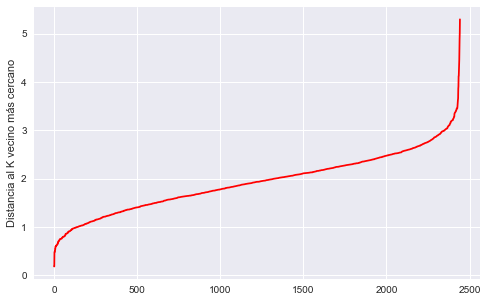

In [65]:
plt.style.use('seaborn')
plt.figure(figsize = (8, 5))
plt.plot(distances, color = 'red')
plt.ylabel('Distancia al K vecino más cercano')
plt.show()

In [66]:
# --- Selección del punto de curvatura máxima ---
kl = KneeLocator(range(len(distances)), distances, curve = 'convex', direction = 'increasing')
kl.elbow

2400

In [67]:
# --- Epsilon óptimo --
epsilon = distances[kl.elbow]
epsilon

3.2151759414960925

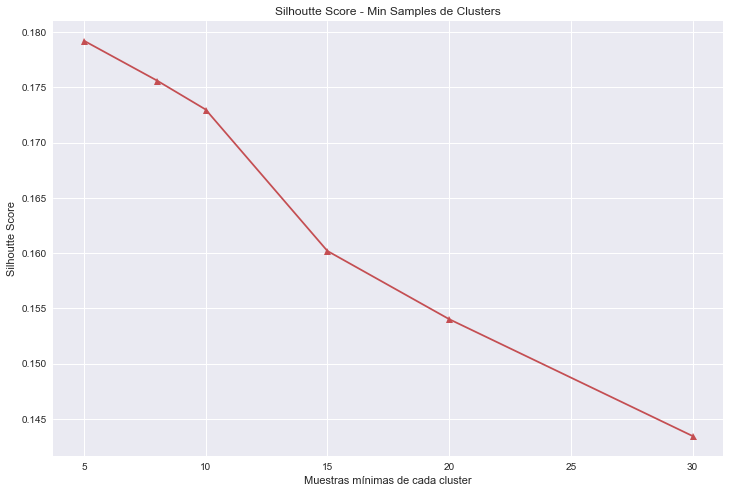

In [68]:
# --- Selección de hiperparámetros min_sample ---
silhoutte_coefs = []

for min_points in [5, 8, 10, 15, 20, 30]:
    model_d = DBSCAN(eps = epsilon, min_samples = min_points)
    model_d.fit(X_pca)
    silhoutte_coefs.append(silhouette_score(X_pca, model_d.labels_))

plt.figure(figsize = (12, 8))
plt.plot([5, 8, 10, 15, 20, 30], silhoutte_coefs, color = 'r', marker = '^')
plt.xlabel('Muestras mínimas de cada cluster')
plt.ylabel('Silhoutte Score')
plt.title('Silhoutte Score - Min Samples de Clusters')
plt.show()

In [262]:
# --- Modelo DBSCAN ---
model_db_pca = DBSCAN(eps = 2.65, min_samples = 7)
model_db_pca.fit(X_pca)

DBSCAN(eps=2.65, min_samples=7)

In [263]:
# --- Evaluación del modelo DBSCAN ---
print(" ### DBSCAN ###")
print('Silhouette Score: ', silhouette_score(X_pca, model_db_pca.labels_))
print('Calinski harabasz score: ', calinski_harabasz_score(X_pca, model_db_pca.labels_))

 ### DBSCAN ###
Silhouette Score:  0.06494001160383253
Calinski harabasz score:  37.278122035589654


In [264]:
# Predicción de los clusters
Cluster_5 = model_db_pca.fit_predict(X_pca)

df_final['Cluster_5']= Cluster_5

# A partir de ahora, sólo trabajaremos con "df_final"
df_final.head(3)

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,...,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,satisfaction,Cluster_1,Cluster_2,Cluster_3,Cluster_4,Cluster_5
0,0,1,0.428280,1,3,1.712718,2,2,2,2,...,5,4,3,-0.146356,1,1,0,1,0,0
1,1,1,0.362354,1,3,-0.806434,2,1,1,1,...,2,2,4,-0.394517,0,0,1,0,0,0
2,0,1,-0.626532,0,1,-0.864560,2,2,2,4,...,3,4,2,-0.394517,0,3,2,2,0,0


In [265]:
df_final['Cluster_5'].value_counts()

 0    1895
-1     537
 1      11
Name: Cluster_5, dtype: int64

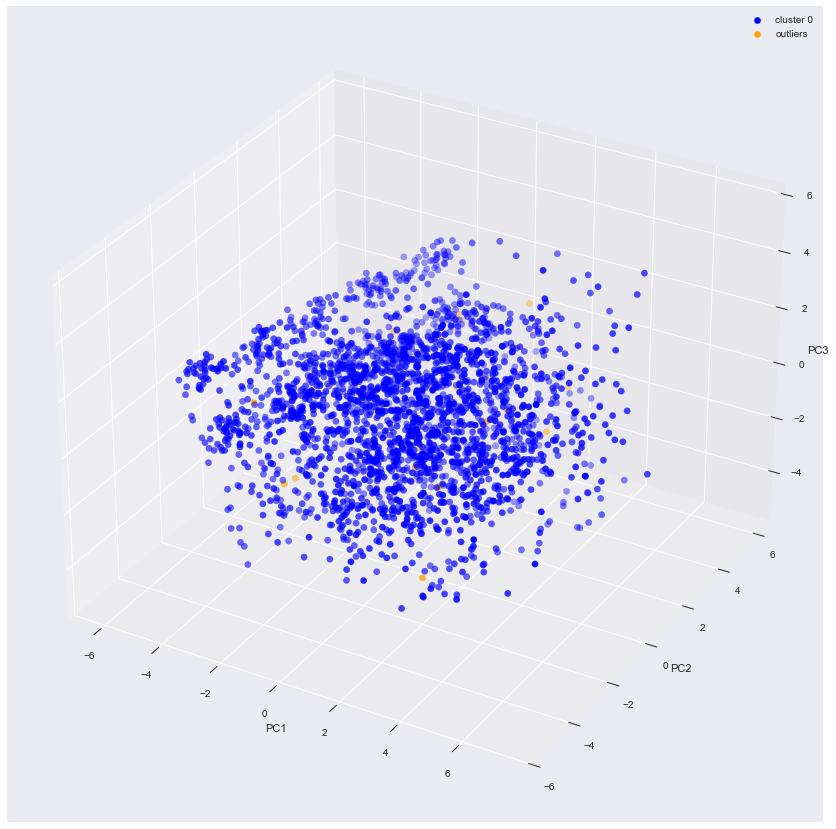

In [266]:
# 3d scatterplot using matplotlib

fig = plt.figure(figsize = (15,15))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_pca[Cluster_4 == 0,0],X_pca[Cluster_4 == 0,1],X_pca[Cluster_4 == 0,2], s = 40 , color = 'blue', label = "cluster 0")
ax.scatter(X_pca[Cluster_4 == -1,0],X_pca[Cluster_4 == -1,1],X_pca[Cluster_4 == -1,2], s = 40 , color = 'orange', label = "outliers")
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.legend()
plt.show()

## Clustering Algorithm: Gaussian Mixture Model

### Dataset Original

Text(0.5, 0, 'Número de Clusters')

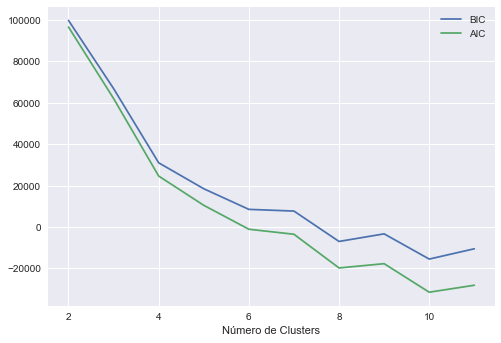

In [267]:
# --- Estimación de hiperparámetros ---

n_components = np.arange(2, 12)

models_g = [GaussianMixture(n_components=n, random_state=123).fit(train_df1_out) for n in n_components]

plt.plot(n_components, [m.bic(train_df1_out) for m in models_g], label="BIC")
plt.plot(n_components, [m.aic(train_df1_out) for m in models_g], label="AIC")
plt.legend()
plt.xlabel("Número de Clusters")

In [268]:
# --- Modelo GMM ---
model_gmm = GaussianMixture(n_components=6, random_state=123, covariance_type = 'full').fit(train_df1_out)

In [269]:
# --- Evaluación del modelo GMM ---
labels_ = model_gmm.predict(train_df1_out)

print(" ### DBSCAN ###")
print('Silhouette Score: ', silhouette_score(train_df1_out, labels_))
print('Calinski harabasz score: ', calinski_harabasz_score(train_df1_out, labels_))

 ### DBSCAN ###
Silhouette Score:  0.017756029013531203
Calinski harabasz score:  76.60990148726837


In [270]:
# Predicción de los clusters
Cluster_6 = model_gmm.fit_predict(train_df1_out)

df_final['Cluster_6']= Cluster_6

# A partir de ahora, sólo trabajaremos con "df_final"
df_final.head(3)

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,...,Inflight service,Cleanliness,Departure Delay in Minutes,satisfaction,Cluster_1,Cluster_2,Cluster_3,Cluster_4,Cluster_5,Cluster_6
0,0,1,0.428280,1,3,1.712718,2,2,2,2,...,4,3,-0.146356,1,1,0,1,0,0,1
1,1,1,0.362354,1,3,-0.806434,2,1,1,1,...,2,4,-0.394517,0,0,1,0,0,0,3
2,0,1,-0.626532,0,1,-0.864560,2,2,2,4,...,4,2,-0.394517,0,3,2,2,0,0,0


In [272]:
df_final['Cluster_6'].value_counts()

0    963
1    676
3    449
5    267
2     69
4     19
Name: Cluster_6, dtype: int64

### Dataset reducido

Text(0.5, 0, 'Número de Clusters')

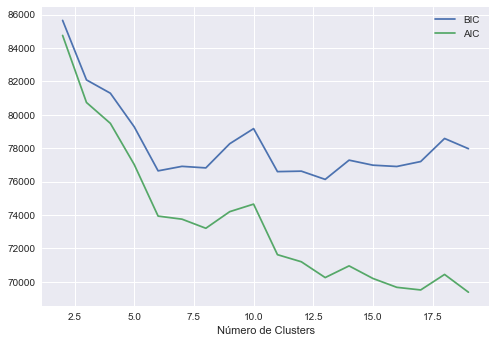

In [273]:
# --- Estimación de hiperparámetros ---

n_components = np.arange(2, 20)

models_g = [GaussianMixture(n_components=n, random_state=123).fit(X_pca) for n in n_components]

plt.plot(n_components, [m.bic(X_pca) for m in models_g], label="BIC")
plt.plot(n_components, [m.aic(X_pca) for m in models_g], label="AIC")
plt.legend()
plt.xlabel("Número de Clusters")

In [274]:
# --- Modelo GMM ---
model_gmm_pca = GaussianMixture(n_components=5, random_state=123, covariance_type = 'full').fit(X_pca)

In [275]:
# --- Evaluación del modelo GMM ---
labels_ = model_gmm_pca.predict(X_pca)

print(" ### DBSCAN ###")
print('Silhouette Score: ', silhouette_score(X_pca, labels_))
print('Calinski harabasz score: ', calinski_harabasz_score(X_pca, labels_))

 ### DBSCAN ###
Silhouette Score:  -0.02666420447329818
Calinski harabasz score:  66.33684192628054


In [276]:
# Predicción de los clusters
Cluster_7 = model_gmm_pca.fit_predict(X_pca)

df_final['Cluster_7'] = Cluster_7

# A partir de ahora, sólo trabajaremos con "df_final"
df_final.head(3)

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,...,Cleanliness,Departure Delay in Minutes,satisfaction,Cluster_1,Cluster_2,Cluster_3,Cluster_4,Cluster_5,Cluster_6,Cluster_7
0,0,1,0.428280,1,3,1.712718,2,2,2,2,...,3,-0.146356,1,1,0,1,0,0,1,2
1,1,1,0.362354,1,3,-0.806434,2,1,1,1,...,4,-0.394517,0,0,1,0,0,0,3,2
2,0,1,-0.626532,0,1,-0.864560,2,2,2,4,...,2,-0.394517,0,3,2,2,0,0,0,4


In [277]:
df_final['Cluster_7'].value_counts()

3    787
4    671
0    415
2    345
1    225
Name: Cluster_7, dtype: int64

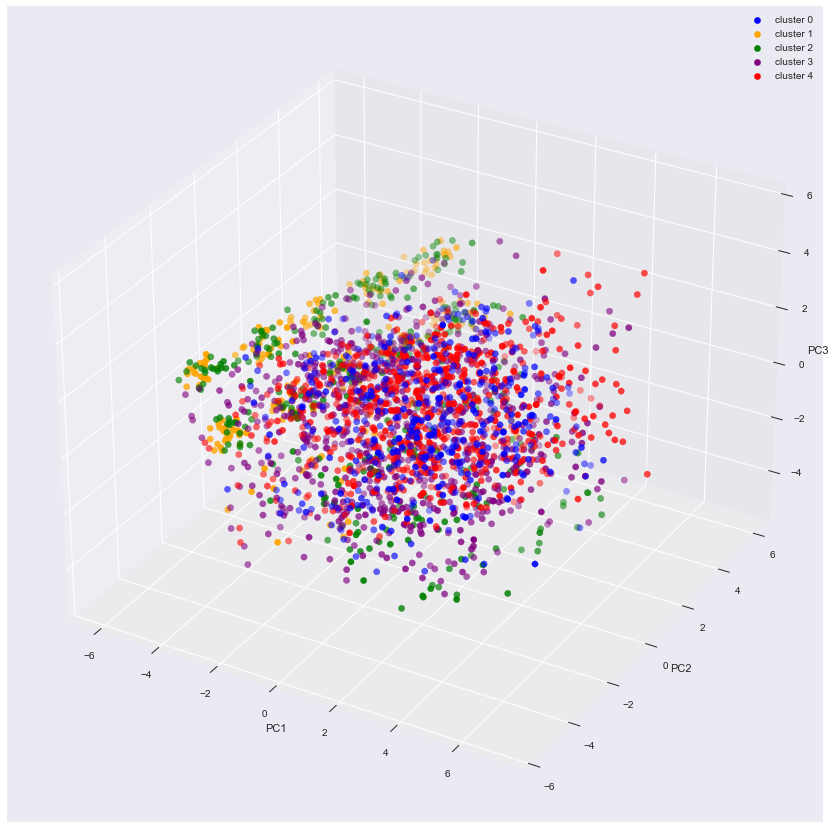

In [279]:
# 3d scatterplot using matplotlib

fig = plt.figure(figsize = (15,15))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_pca[Cluster_7 == 0,0],X_pca[Cluster_7 == 0,1],X_pca[Cluster_7 == 0,2], s = 40 , color = 'blue', label = "cluster 0")
ax.scatter(X_pca[Cluster_7 == 1,0],X_pca[Cluster_7 == 1,1],X_pca[Cluster_7 == 1,2], s = 40 , color = 'orange', label = "cluster 1")
ax.scatter(X_pca[Cluster_7 == 2,0],X_pca[Cluster_7 == 2,1],X_pca[Cluster_7 == 2,2], s = 40 , color = 'green', label = "cluster 2")
ax.scatter(X_pca[Cluster_7 == 3,0],X_pca[Cluster_7 == 3,1],X_pca[Cluster_7 == 3,2], s = 40 , color = 'purple', label = "cluster 3")
ax.scatter(X_pca[Cluster_7 == 4,0],X_pca[Cluster_7 == 4,1],X_pca[Cluster_7 == 4,2], s = 40 , color = 'red', label = "cluster 4")
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.legend()
plt.show()

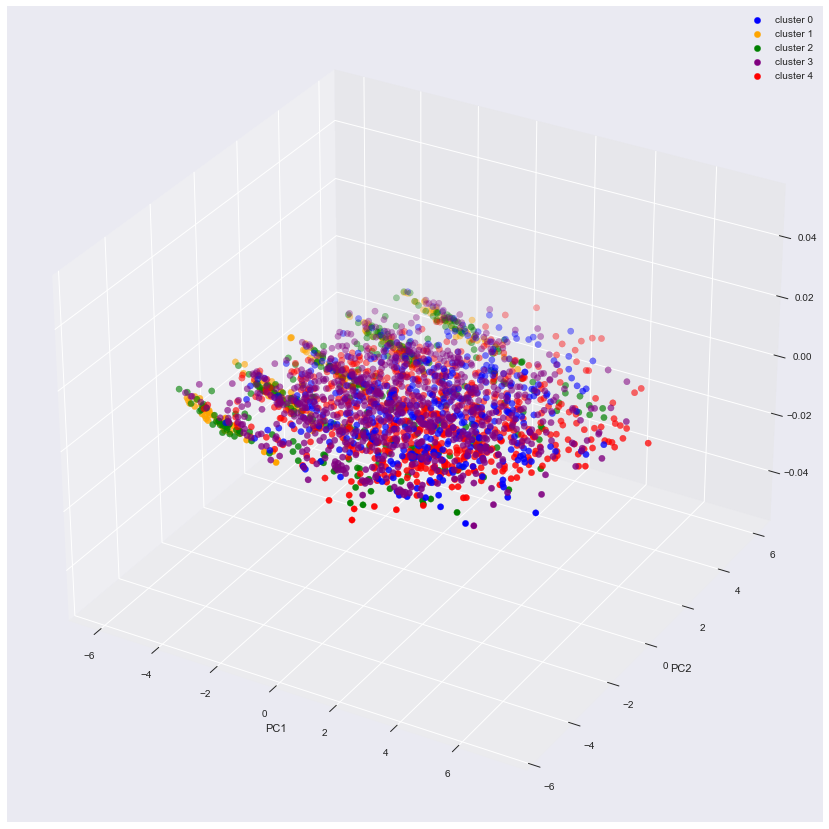

In [280]:
# 3d scatterplot using matplotlib

fig = plt.figure(figsize = (15,15))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_pca[Cluster_7 == 0,0],X_pca[Cluster_7 == 0,1], s = 40 , color = 'blue', label = "cluster 0")
ax.scatter(X_pca[Cluster_7 == 1,0],X_pca[Cluster_7 == 1,1], s = 40 , color = 'orange', label = "cluster 1")
ax.scatter(X_pca[Cluster_7 == 2,0],X_pca[Cluster_7 == 2,1], s = 40 , color = 'green', label = "cluster 2")
ax.scatter(X_pca[Cluster_7 == 3,0],X_pca[Cluster_7 == 3,1], s = 40 , color = 'purple', label = "cluster 3")
ax.scatter(X_pca[Cluster_7 == 4,0],X_pca[Cluster_7 == 4,1], s = 40 , color = 'red', label = "cluster 4")
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.legend()
plt.show()